<a href="https://colab.research.google.com/github/iannickgagnon/notebooks/blob/main/PyTorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Étape 1 : Préparer l'environnement

In [2]:
!pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# Étape 2 : Importer les bibliothèques nécessaires

In [13]:
# Bibliothèque principale de PyTorch pour les tenseurs, calculs sur GPU, etc.
import torch

# Module contenant les classes pour définir des réseaux de neurones
import torch.nn as nn

# Contient des optimisateurs (ex: SGD, Adam) pour l'entraînement de modèles
import torch.optim as optim

# Bibliothèque PyTorch pour les datasets, modèles pré-entraînés, et utilitaires d'images
import torchvision

# Outils pour transformer les images
import torchvision.transforms as transforms

# Bibliothèque2 de visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Pour afficher la matrice de confusion après l'entraînement
from sklearn.metrics import confusion_matrix

# Étape 3 : Charger et préparer les données (MNIST)

In [4]:
MNIST_AVG = 0.1307  # Moyenne des pixels des images de MNIST
MNIST_STD = 0.3081  # Écart-type des pixels des images de MNIST

# Crée un pipeline de transformations qui :
#   1. Convertit une image PIL ou NumPy en tenseur PyTorch (transforms.ToTensor)
#   2. Normalise les pixels pour obtenir des valeurs entre 0 et 1 (transforms.Normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MNIST_AVG,), (MNIST_STD,))
])

# ********************************************
# Définition du jeu de données à télécharger *
# ********************************************

train_set = torchvision.datasets.MNIST(
    root='./data',           # Dossier où les données seront stockées
    train=True,              # Télécharge les données d'entraînement
    download=True,           # Télécharge automatiquement si les fichiers n'existent pas
    transform=transform      # Applique les transformations définies plus haut
)

test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,             # Cette fois, on télécharge les données de test
    download=True,
    transform=transform
)

# **********************************
# Téléchargement du jeu de données *
# **********************************

train_loader = torch.utils.data.DataLoader(
    train_set,               # Jeu d'entraînement
    batch_size=64,           # Nombre d'exemples par lot
    shuffle=True             # Mélange les données à chaque époque pour éviter les biais
)

test_loader = torch.utils.data.DataLoader(
    test_set,                # Jeu de test
    batch_size=1000,         # Plus gros batch pour accélérer l'évaluation
    shuffle=False            # Pas besoin de mélanger les données de test
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 64.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 25.3MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 79.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.81MB/s]


# Étape 4 : Définir l'architecture du CNN

Pour calculer la dimension de l'image retournée suite à une convolution 2D en fonction des dimensions d'origine, du padding, de la taille du noyau et du stride:
$$$$
$$\mathrm{Output\_size = \left \lfloor \frac{Input\_size + 2 \times Padding - Kernel\_size}{Stride}\right \rfloor + 1}$$
$$$$
$$\mathrm{O = \left \lfloor \frac{I+ 2P - K}{S}\right \rfloor + 1}$$
$$$$
En isolant le padding $\mathrm{\left(P\right)}$ :
$$$$
$$\mathrm{P = \left \lfloor \frac{(I - 1) \times S + K - I}{2}\right \rfloor}$$
$$$$

In [7]:
class CNNMNIST(nn.Module):

    # Couche no.1 - Convolution 2D
    __NB_CHANNELS_1 = 1   # Le nombre de canaux des images (niveau de gris)
    __INPUT_SIZE_1 = 28   # La taille de l'image d'entrée (28 x 28)
    __OUTPUT_SIZE_1 = 28  # La taille de l'image de sortie après la première convolution
    __NB_FILTERS_1 = 32   # Le nombre de filtres de la première couche de convolution
    __KERNEL_SIZE_1 = 3   # La taille des filtres de convolution
    __STRIDE_1 = 1        # Le pas de la convolution

    # Couche no.2 - Convolution 2D
    __NB_CHANNELS_2 = __NB_FILTERS_1
    __INPUT_SIZE_2 = __OUTPUT_SIZE_1
    __OUTPUT_SIZE_2 = __OUTPUT_SIZE_1
    __NB_FILTERS_2 = 64
    __KERNEL_SIZE_2 = 3
    __STRIDE_2 = 1

    # Couche no.3 - Max Pooling
    __MAX_POOL_SIZE_3 = 2

    # Couche no.4 - Dropout
    __DROPOUT_RATE_4 = 0.25

    def __init__(self):

      # Pour le suivi automatique des paramètres, l'enregistrement des couches, gestion des hooks, etc.
      super(CNNMNIST, self).__init__()

      # Couche no.1 : Convolution (entrée 1 x 28 x 28, sortie 32 x 28 x 28)
      padding_layer_1 = self.__calculate_padding(self.__INPUT_SIZE_1,
                                                  self.__KERNEL_SIZE_1,
                                                  self.__STRIDE_1)

      self.conv1 = nn.Conv2d(self.__NB_CHANNELS_1,
                              self.__NB_FILTERS_1,
                              kernel_size=self.__KERNEL_SIZE_1,
                              padding=padding_layer_1)

      # Couche no.2 : Convolution (entrée 32 x 28 x 28, sortie 64 x 28 x 28)
      padding_layer_2 = self.__calculate_padding(self.__NB_FILTERS_1,
                                                  self.__KERNEL_SIZE_2,
                                                  self.__STRIDE_2)

      self.conv2 = nn.Conv2d(self.__NB_CHANNELS_2,
                              self.__NB_FILTERS_2,
                              kernel_size=self.__KERNEL_SIZE_2,
                              padding=padding_layer_2)

      # Couche no.3 : Max Pooling (entrée A x B x C, sortie A x B // 2 x C // 2)
      self.pool = nn.MaxPool2d(self.__MAX_POOL_SIZE_3,
                                self.__MAX_POOL_SIZE_3)

      # Couche no.4 : Désactiver aléatoirement 25% des neurones pour éviter le surapprentissage
      self.dropout = nn.Dropout(self.__DROPOUT_RATE_4)

      # Couche no.5 :
      self.fc1 = nn.Linear(64 * 7 * 7, 128)
      self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
      '''
      Couches:
        01. Convolution 2D (entrée 1 x 28 x 28, sortie 32 x 28 x 28)
        02. RELU
        03. Max Pooling (entrée 32 x 28 x 28, sortie 32 x 14 x 14)
        04. Convolution 2D (entrée 32 x 14 x 14, sortie 64 x 14, 14)
        05. RELU
        06. Max Pooling (entrée 64 x 14 x 14, sortie 64 x 7 x 7)
        07. Dropout (entrée 64 x 7 x 7, sortie 64 x 7 x 7)
        08. Fully Connected (entrée 64 x 7 x 7, sortie 64 x 7 x 7 = 3136)
        09. RELU
        10. Fully Connected (entrée 128, sortie 10)
      '''

      # Convolution -> RELU -> Max Pool
      x = self.pool(torch.relu(self.conv1(x)))
      x = self.pool(torch.relu(self.conv2(x)))

      # Aplatir de 3D à 1D
      x = x.view(-1, 64 * 7 * 7)

      # Désactivation aléatoire
      x = self.dropout(x)

      # Couche pleinement connectée -> RELU
      x = torch.relu(self.fc1(x))

      # Couche pleinement connectée
      x = self.fc2(x)

      return x

    @staticmethod
    def __calculate_padding(input_size, kernel_size, stride):
        return ((input_size - 1) * stride + kernel_size - input_size) // 2

    @staticmethod
    def __calculate_output_size_conv(input_size, padding_size, kernel_size, stride):
        return (input_size + 2 * padding_size - kernel_size) // stride + 1


# Étape 5 : Instancier (1) le modèle, (2) la fonction objective et (3) l'optimiseur

In [8]:
# Définir l'appareil sur lequel sera exécuté le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Relier le modèle et l'appareil
model = CNNMNIST().to(device)

# Instancier la fonction objective
criterion = nn.CrossEntropyLoss()

# Instancier l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Étape 6 : Entraîner le modèle

In [9]:
def train(model, train_loader, optimizer, criterion, epochs=5):

  # Active le mode entraînement
  model.train()

  # Boucle sur chaque époque
  for epoch in range(epochs):

    # Accumulateur pour la perte totale de l'époque
    running_loss = 0.0

    # Boucle sur chaque batch
    for images, labels in train_loader:

      # Envoie les données sur le bon appareil
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()               # Réinitialise les gradients à zéro
      outputs = model(images)             # Passe les images dans le modèle (forward pass)
      loss = criterion(outputs, labels)   # Calcule la perte entre les prédictions et les vraies étiquettes
      loss.backward()                     # Calcul des gradients via la rétropropagation
      optimizer.step()                    # Mise à jour des poids du modèle
      running_loss += loss.item()         # Ajoute la perte du batch à la somme totale

    # Affiche la perte moyenne de l'époque
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


# Étape 7 : Évaluer le modèle

In [14]:
def test(model, test_loader, classes, show_errors=True, max_errors=5):

  # Met le modèle en mode évaluation (désactive le Dropout, fixe les BatchNorm)
  model.eval()

  nb_correct = 0    # Compteur de bonnes prédictions
  nb_total = 0      # Compteur total d'exemples
  all_preds = []    # Toutes les prédictions
  all_labels = []   # Tous les étiquettes
  errors = []       # Images mal classées

  with torch.no_grad():  # Désactive la rétropropagation (plus rapide et moins gourmand)

    # Pour chaque batch
    for images, labels in test_loader:

      # Envoie les données sur le bon appareil (CPU ou GPU)
      images, labels = images.to(device), labels.to(device)

      # Prédire les probabilités de classes de la batch courante
      outputs = model(images)

      # Récupère la classe avec le score le plus élevé
      _, predicted = torch.max(outputs.data, 1)

      # Mise à jour du total d'exemples
      nb_total += labels.size(0)

      # Mise à jour du total de bonnes prédictions
      nb_correct += (predicted == labels).sum().item()

      # Stocke les prédictions et les étiquettes réelles pour la matrice de confusion
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

      # Si on veut afficher des erreurs
      if show_errors and len(errors) < max_errors:

        # Récupère les indices mal prédits dans le batch courant
        wrong_indices = (predicted != labels).nonzero(as_tuple=True)[0]

        # Ajoute des exemples à la liste des erreurs
        for idx in wrong_indices[:max_errors - len(errors)]:
          errors.append((images[idx].cpu(), predicted[idx].item(), labels[idx].item()))

  # Affiche les images mal classées
  if show_errors and errors:
    print("\nExemples de prédictions incorrectes :")
    for i, (img, pred, true) in enumerate(errors):
      plt.subplot(1, max_errors, i + 1)
      plt.axis('off')
      plt.title(f"P:{pred}, T:{true}")
      plt.imshow(img.squeeze(), cmap='gray')
    plt.tight_layout()
    plt.show()

  # Affichee la matrice de confusion
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=classes, yticklabels=classes)
  plt.xlabel('Prédiction')
  plt.ylabel('Vrai label')
  plt.title('Matrice de confusion')
  plt.show()

  # Affichee l'exactitude sur le jeu de test
  print(f"\nAccuracy: {100 * nb_correct / nb_total:.2f}%")

Étape 8 : Lancer l'entraînement et l'évaluation

Epoch 1, Loss: 0.0201

Exemples de prédictions incorrectes :


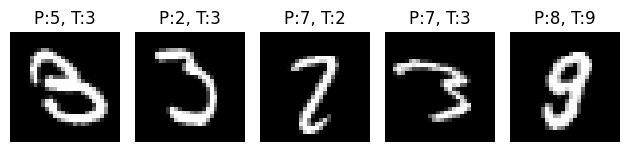

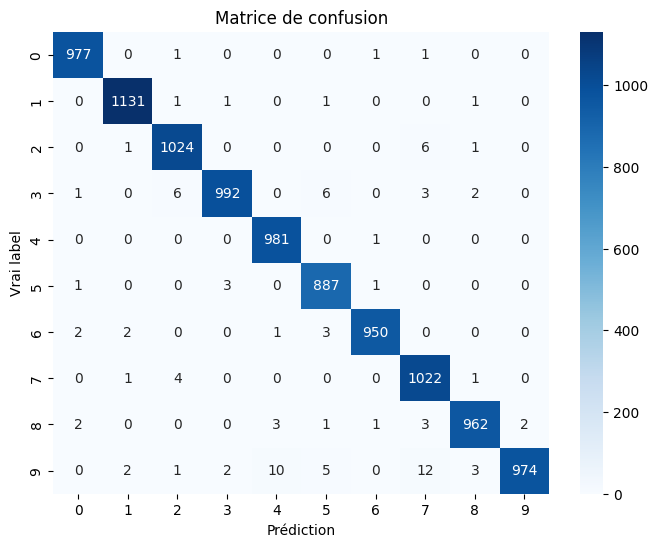


Accuracy: 99.00%


In [16]:
train(model, train_loader, optimizer, criterion, epochs=1)
classes = [str(i) for i in range(10)]
test(model, test_loader, classes)